<a href="https://colab.research.google.com/github/Fer-L/cyclonet/blob/main/Cyclonet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comandos para rodar o ambiente no Anaconda

pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws


jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8889 --NotebookApp.port_retries=0

# Import

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications.xception import decode_predictions
from keras.models import Model

# Configura as imagens

In [ ]:
data_directory_train = r'E:\Documentos\Faculdade\cyclonet\data\train'
data_directory_val = r'E:\Documentos\Faculdade\cyclonet\data\validation'
data_directory_test = r'E:\Documentos\Faculdade\cyclonet\data\test'
image_size = (224, 224)
input_shape = image_size + (3,)
use_data_augmentation = True
validation_split = 0.2
color_mode = "rgb"
classes = ['Ciclones', 'Oceano']

# Carregamento dos dados

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory_train,
    color_mode=color_mode,
    image_size=image_size,
    batch_size = 256
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory_val,
    color_mode=color_mode,
    image_size=image_size,
    batch_size = 256
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory_test,
    color_mode=color_mode,
    image_size=image_size,
    batch_size = 256
)

def process(image, label):
    image = tf.cast(image / 255, tf.float32)
    return image, label



train = train.map(process)
validation = validation.map(process)
test = test.map(process)


Found 651 files belonging to 2 classes.
Found 217 files belonging to 2 classes.
Found 219 files belonging to 2 classes.


# Mostrando as imagens

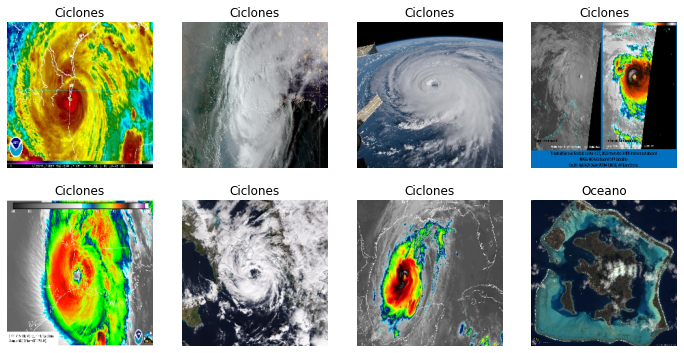

In [ ]:
rows, columns = 2, 4
images, labels = list(*train.take(1))
plt.figure(figsize=(12, 6))

for i in range(rows * columns):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(images[i])
    title = classes[int(labels[i])]
    plt.title(title)
    plt.axis('off')
plt.show()

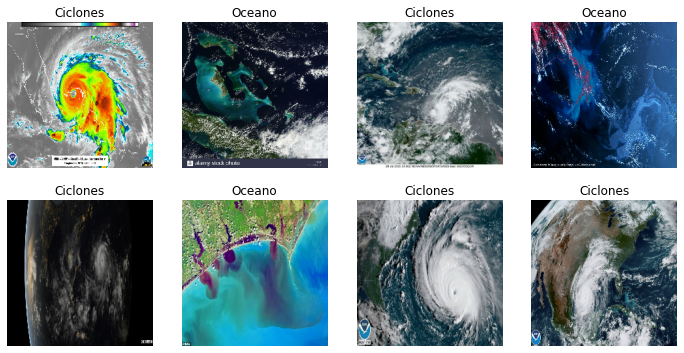

In [ ]:
rows, columns = 2, 4
images, labels = list(*validation.take(1))
plt.figure(figsize=(12, 6))

for i in range(rows * columns):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(images[i])
    title = classes[int(labels[i])]
    plt.title(title)
    plt.axis('off')
plt.show()

# Data Augmentation


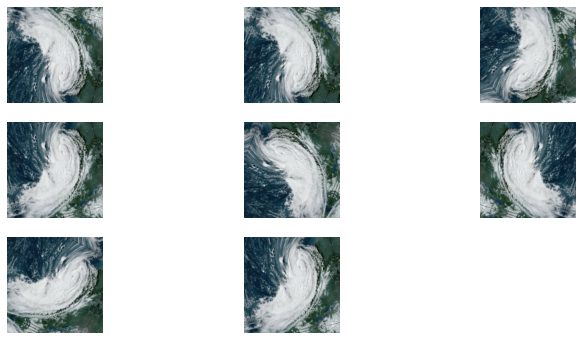

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

rows, columns = 2, 4
images, labels = list(*validation.take(1))

plt.figure(figsize=(12, 6))
for images, labels in train.take(1):
	for i in range(rows * columns):
		augmented_images = data_augmentation(images)
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(augmented_images[0])
		plt.axis("off")

# Transfer Learning

Utilizando o Xception

In [ ]:
pre_trained_model = tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
pre_trained_model.trainable = False
pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
for layer in pre_trained_model.layers[:]:
   layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = pre_trained_model(inputs, training=False)
x = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
x = layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
random_flip_7 (RandomFlip)   (None, 7, 7, 2048)        0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
______________________________________

In [ ]:
history = model.fit(train, validation_data = validation, epochs=10)

Epoch 1/10
3/3 [==============================] - 42s 14s/step - loss: 0.7315 - accuracy: 0.5146 - val_loss: 0.7118 - val_accuracy: 0.6498
Epoch 2/10
3/3 [==============================] - 46s 15s/step - loss: 0.6423 - accuracy: 0.6452 - val_loss: 0.6159 - val_accuracy: 0.6728
Epoch 3/10
3/3 [==============================] - 55s 18s/step - loss: 0.5472 - accuracy: 0.7066 - val_loss: 0.5295 - val_accuracy: 0.7604
Epoch 4/10
3/3 [==============================] - 61s 20s/step - loss: 0.4878 - accuracy: 0.8049 - val_loss: 0.4899 - val_accuracy: 0.8111
Epoch 5/10
3/3 [==============================] - 62s 21s/step - loss: 0.4426 - accuracy: 0.8372 - val_loss: 0.4493 - val_accuracy: 0.8111
Epoch 6/10
3/3 [==============================] - 63s 21s/step - loss: 0.4000 - accuracy: 0.8402 - val_loss: 0.4378 - val_accuracy: 0.8065
Epoch 7/10
3/3 [==============================] - 63s 21s/step - loss: 0.3792 - accuracy: 0.8418 - val_loss: 0.4197 - val_accuracy: 0.8157
Epoch 8/10
3/3 [===========

# Gráficos

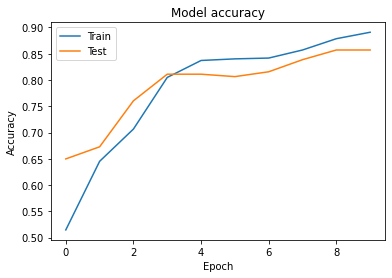

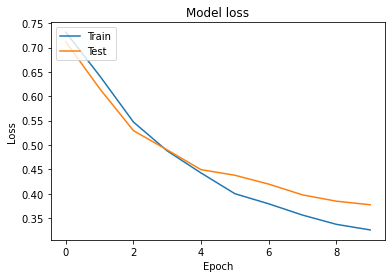

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predições

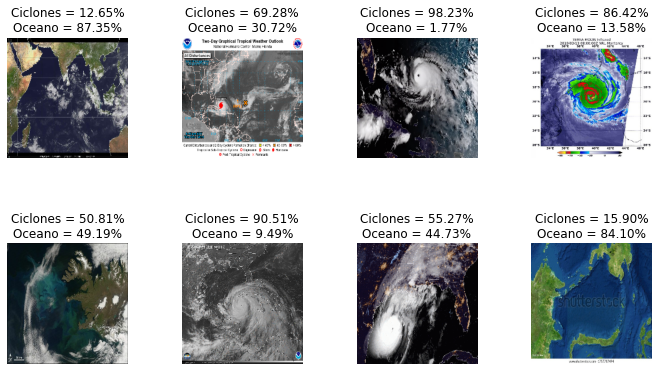

In [ ]:
rows, columns = 2, 4
images, labels = list(*test.take(1))
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.7)
predictions = model.predict(images)

for i in range(rows * columns):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(images[i])
    title = '\n'.join([f'{classes[j]} = {predictions[i][j] * 100:.2f}%' for j in range(len(classes))])
    plt.title(title)
    plt.axis('off')
plt.show()